# Forecasting

### Student: Rodolfo Lerma

In this assignment, we will explore the python package [statsmodels](http://www.statsmodels.org/dev/tsa.html) to forecast the time series data. You will learn to use different time series modeling technique for forecasting.

Learning Objectives:

- Decompose time series into autocorrelation, seasonality, trend, and noise. 
- Explain the effects of exponential smoothing models and differentiate them from other models.
- Apply and evaluate the results of an autoregressive model. 
- Apply and evaluate the results of a moving average model. 
- Apply and evaluate the results of an autoregressive integrated moving average model.
- Apply and evaluate the results of ARIMA model for forecasting (time series prediction).


In [1]:
# # install packages
# import sys
# !pip3 install --prefix {sys.prefix} statsmodels

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

----------

## Air Passenger Dataset
This dataset provides monthly totals of international airline passengers from 1949 to 1960. You can find a copy of the dataset on [Kaggle](https://www.kaggle.com/rakannimer/air-passengers) or [R datasets](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html).

In [3]:
df = pd.read_csv('./airline-passengers.csv', index_col=[0], parse_dates=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df= df.rename(columns={'airline passengers': 'passengers'})
df.head()

,passengers
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.tail()

,passengers
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


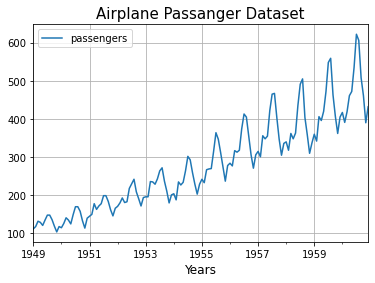

In [5]:
# split the data into train and test
train, test = df.iloc[:130, [0]], df.iloc[130:, [0]]

df.plot()
pyplot.title('Airplane Passanger Dataset', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

As it is possible to see the data set contains monthly Airplane Passanger Data from 1949 to 1960.

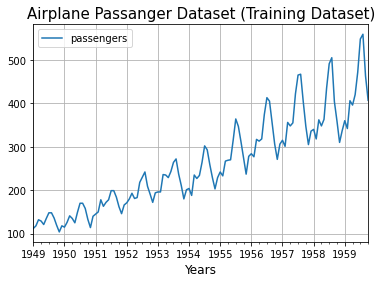

In [6]:
train.plot()
pyplot.title('Airplane Passanger Dataset (Training Dataset)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

In [7]:
train.shape

(130, 1)

The train data set contains 130 entries

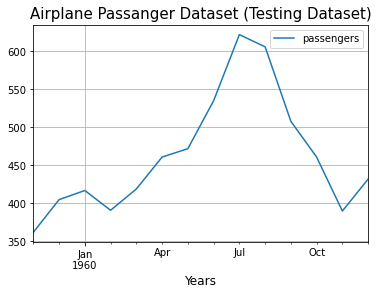

In [8]:
test.plot()
pyplot.title('Airplane Passanger Dataset (Testing Dataset)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

In [9]:
test.shape

(14, 1)

The test data set have 14 datapoints which reflect the last 14 months.

<AxesSubplot:ylabel='passengers'>

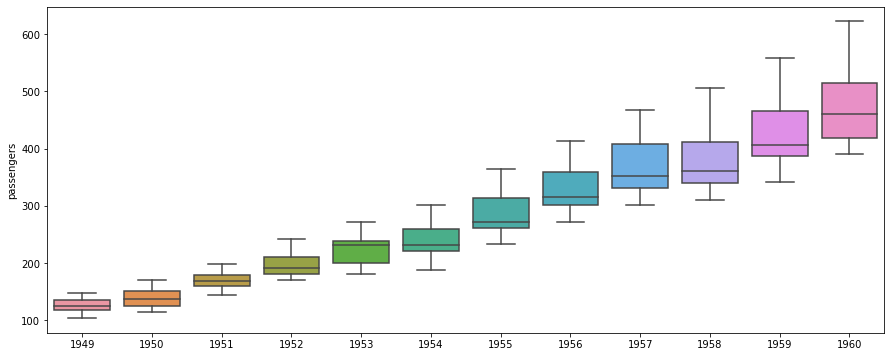

In [10]:
import seaborn as sns
fig, ax = pyplot.subplots(figsize=(15,6))
sns.boxplot(df.passengers.index.year, df.passengers, ax=ax)

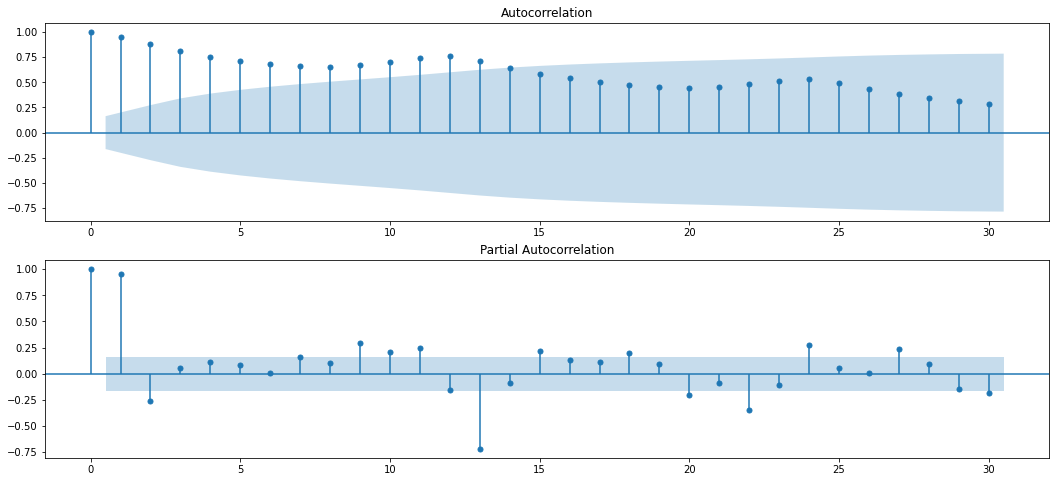

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
pyplot.figure()
pyplot.subplot(211)
plot_acf(df.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

It is possible to notice that the data is Non-stationary, as the future observations are correlated to previous values.

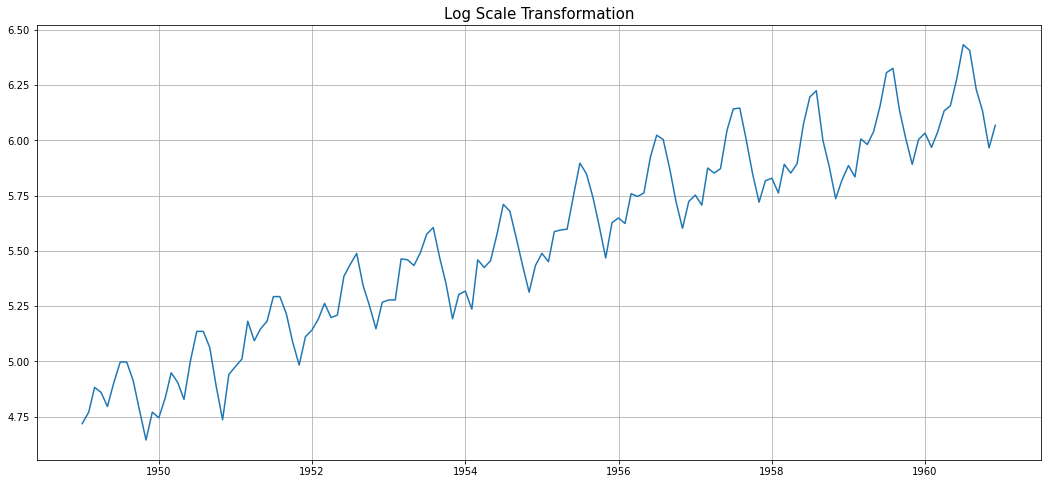

In [12]:
ts_log = np.log(df)
pyplot.plot(ts_log)
pyplot.title('Log Scale Transformation', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

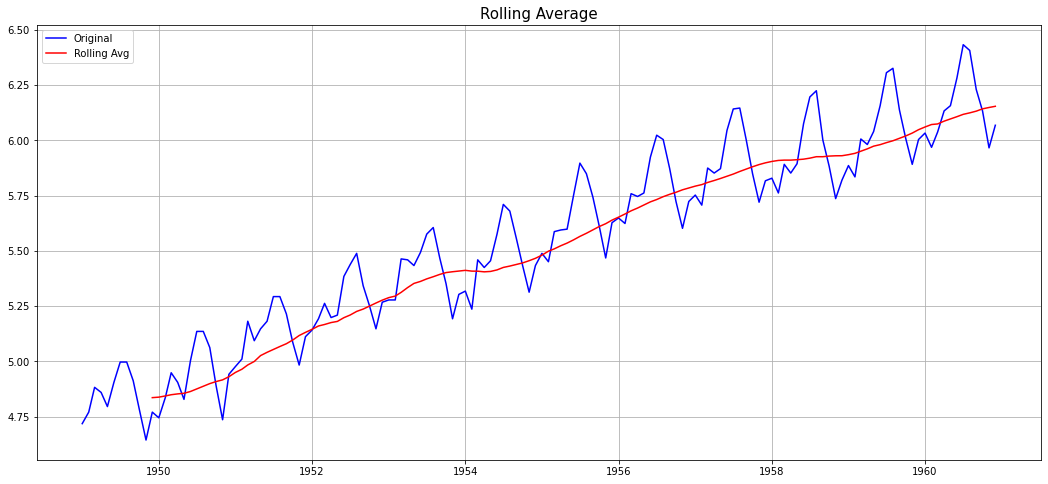

In [13]:
#Determing rolling statistics
rolmean = ts_log.rolling(12).mean()

#Plot rolling statistics:
orig = pyplot.plot(ts_log, color='blue',label='Original')
mean = pyplot.plot(rolmean, color='red', label='Rolling Avg')
pyplot.legend(loc='best')
pyplot.title('Rolling Average', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

In [14]:
ts_log_moving_avg_diff = ts_log - rolmean

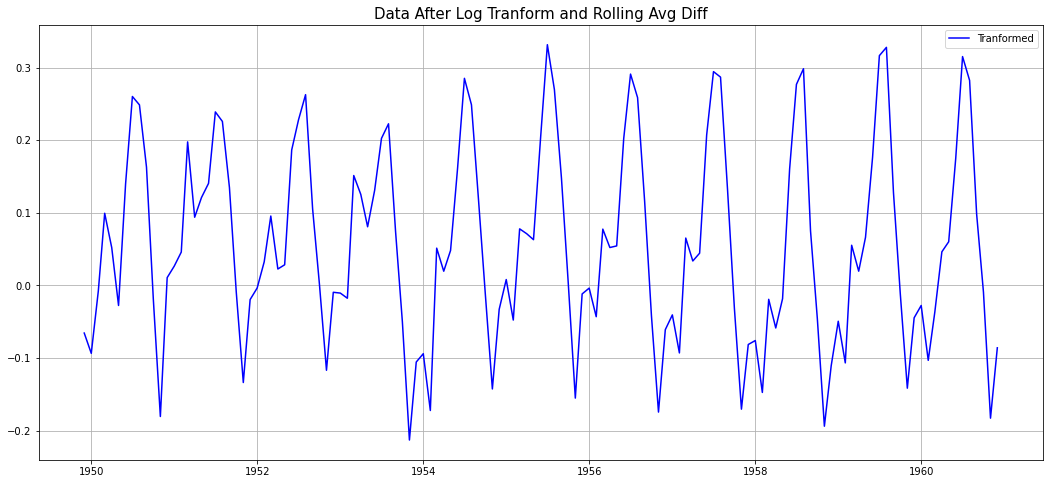

In [15]:
orig = pyplot.plot(ts_log_moving_avg_diff, color='blue',label='Tranformed')
#mean = pyplot.plot(rolmean, color='red', label='Rolling Avg')
pyplot.legend(loc='best')
pyplot.title('Data After Log Tranform and Rolling Avg Diff', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

The log transformation reduces the change of the variation of the data as it grows thru time.

### Question 1.1: Using [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) API from `statsmodels.tsa.seasonal`, apply additive decomposition to the airline passenger dataset and plot each components from the decomposition.

Decomposition of Original Data Set: Additive


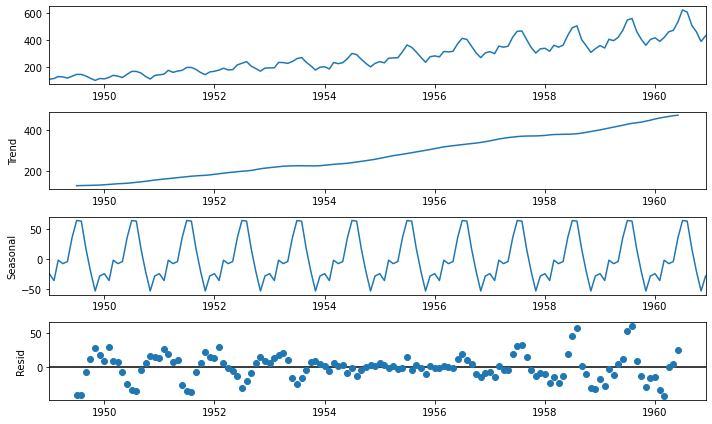

In [16]:
# additive decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
test_size = test.shape[0]
print('Decomposition of Original Data Set: Additive')
rcParams['figure.figsize'] = 10, 6
result = seasonal_decompose(df, model='additive')
fig = result.plot()
pyplot.show()

### Question 1.2: Using [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) API from `statsmodels.tsa.seasonal`, apply multiplication decomposition to the same airline passenger dataset and plot each components from the decomposition. Which decomposition makes more sense in this dataset? 

Decomposition of Original Data Set: Multiplicative


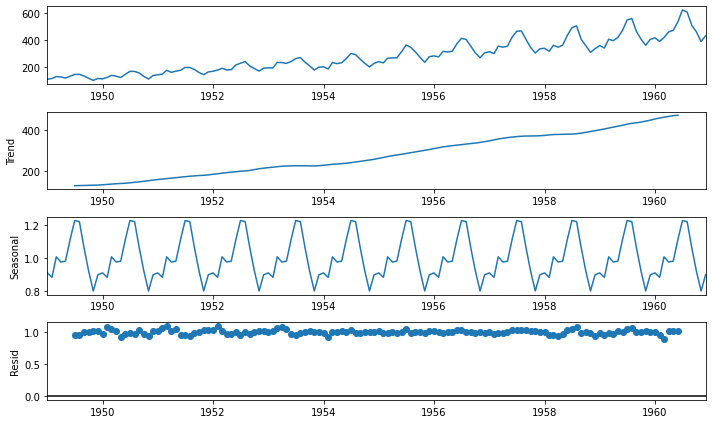

In [17]:
# multiplicative decomposition
print('Decomposition of Original Data Set: Multiplicative')
rcParams['figure.figsize'] = 10, 6
results = seasonal_decompose(df, model='multiplicative')
fig = results.plot()
pyplot.show()

### 1.3: Decompostion of the Log Transform data set

Decomposition of Log Transform Dataset


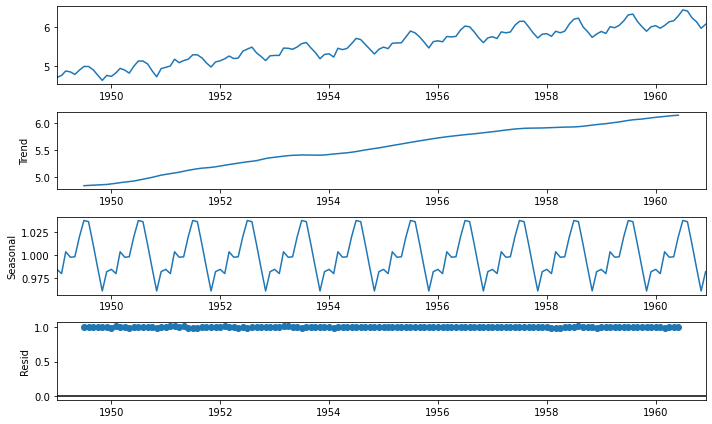

In [18]:
# Log Transform decomposition
print('Decomposition of Log Transform Dataset')
rcParams['figure.figsize'] = 10, 6
result = seasonal_decompose(ts_log, model='multiplicative')
fig = result.plot()
pyplot.show()

In [19]:
train_log, test_log = ts_log.iloc[:130, [0]], ts_log.iloc[130:, [0]]

In [20]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
train_logm, test_logm = ts_log_diff.iloc[:130, [0]], ts_log_diff.iloc[130:, [0]]

----------

### Question 2.1: Apply the simple exponential smoothing technique ([SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameter `smoothing_level` and see how it impacts the model accuracy. 

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [22]:
#Alpha = 0.2
fit1 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=1, 
                                                                 optimized=False)
fcast1 = fit1.forecast(test_size).rename(r"$\alpha=0.2$")

#Alpha = 0.6                                                                 
fit2 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.6, 
                                                                 optimized=False)
fcast2 = fit2.forecast(test_size).rename(r"$\alpha=0.6$")

#Alpha = 0.8                                                                   
fit3 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.8, 
                                                                 optimized=False)
fcast3 = fit3.forecast(test_size).rename(r"$\alpha=0.8$")

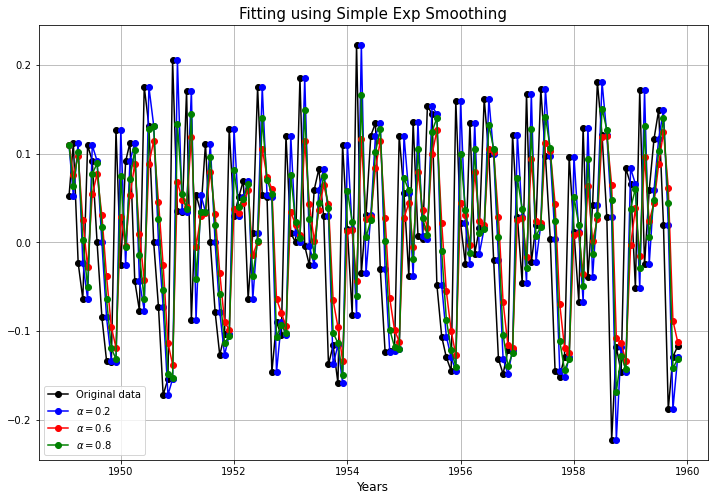

In [23]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(fit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.2$")
pyplot.plot(fit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
pyplot.plot(fit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
pyplot.title('Fitting using Simple Exp Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

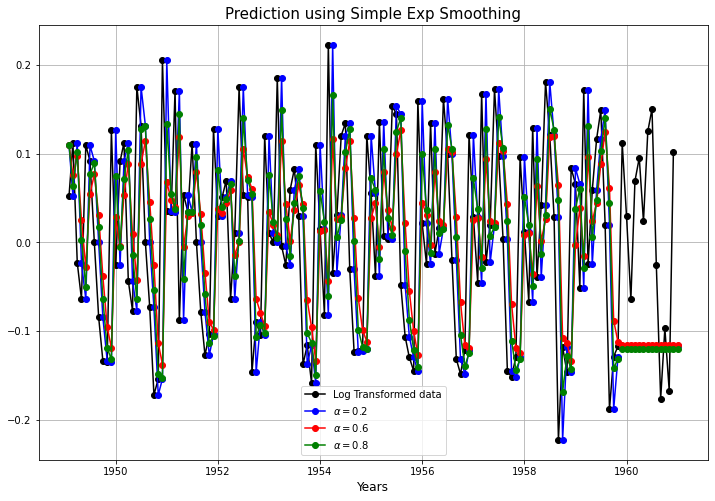

In [24]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Log Transformed data")
pyplot.plot(fit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.2$")
(line1,) = pyplot.plot(fcast1, marker="o", color="blue")
pyplot.plot(fit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
(line2,) = pyplot.plot(fcast2, marker="o", color="red")
pyplot.plot(fit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
(line3,) = pyplot.plot(fcast3, marker="o", color="green")
pyplot.title('Prediction using Simple Exp Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

In [25]:
predictions_SimExp_diff = pd.Series(fit1.fittedvalues, copy=True)
predictions_SimExp_diff = predictions_SimExp_diff.append(fit1.forecast(test_size))
predictions_SimExp_diff_cumsum = predictions_SimExp_diff.cumsum()
predictions_SimExp_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_SimExp_log = predictions_SimExp_log.add(predictions_SimExp_diff_cumsum,fill_value=0)
predictions_SimExp = np.exp(predictions_SimExp_log)

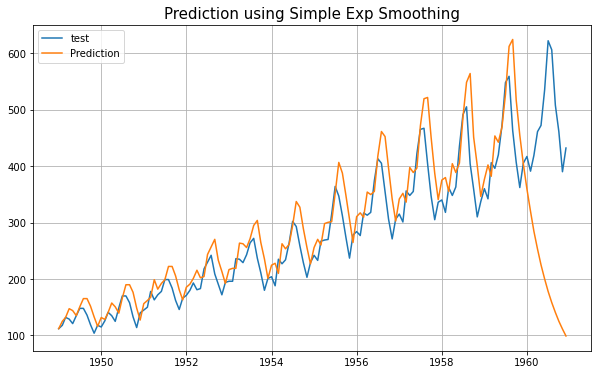

In [26]:
pyplot.plot(df, label = "test")
pyplot.plot(predictions_SimExp[:-1], label = "Prediction")
pyplot.title('Prediction using Simple Exp Smoothing', fontsize = 15)
pyplot.grid()
pyplot.legend()

In [27]:
print("rmse: " + str(sqrt(mean_squared_error(test, predictions_SimExp.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_SimExp.iloc[130:-1])))

rmse: 278.37715403866804
mae: 239.4500863981309


----------

### Question 2.2: Apply the HWES technique ([ExponentialSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [29]:
#Alpha = 0.2
expfit1 = ExponentialSmoothing(train_logm, 
                               initialization_method="heuristic").fit(smoothing_level=0.3, 
                                                                 optimized=False)
expfcast1 = expfit1.forecast(test_size).rename(r"$\alpha=0.2$")

#Alpha = 0.6                                                                 
expfit2 = ExponentialSmoothing(train_logm, 
                               initialization_method="heuristic").fit(smoothing_level=0.6, 
                                                                 optimized=False)
expfcast2 = expfit2.forecast(test_size).rename(r"$\alpha=0.6$")

#Alpha = 0.8                                                                   
expfit3 = ExponentialSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.2, 
                                                                 optimized=False)
expfcast3 = expfit3.forecast(test_size).rename(r"$\alpha=0.8$")

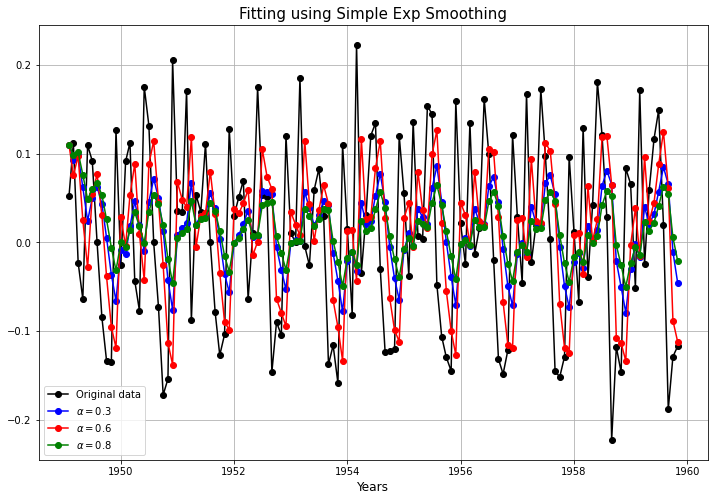

In [30]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(expfit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.3$")
pyplot.plot(expfit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
pyplot.plot(expfit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
pyplot.title('Fitting using Simple Exp Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

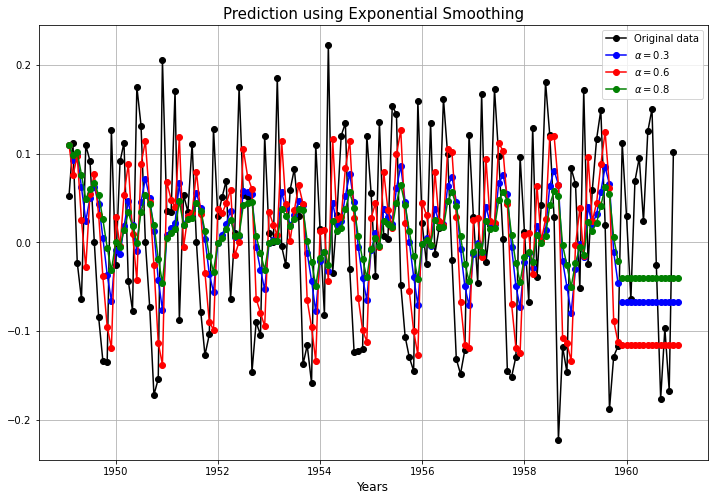

In [31]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(expfit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.3$")
(line1,) = pyplot.plot(expfcast1, marker="o", color="blue")
pyplot.plot(expfit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
(line2,) = pyplot.plot(expfcast2, marker="o", color="red")
pyplot.plot(expfit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
(line3,) = pyplot.plot(expfcast3, marker="o", color="green")
pyplot.title('Prediction using Exponential Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

In [32]:
predictions_ExpSm_diff = pd.Series(expfit1.fittedvalues, copy=True)
predictions_ExpSm_diff = predictions_ExpSm_diff.append(expfit1.forecast(test_size))
predictions_ExpSm_diff_cumsum = predictions_ExpSm_diff.cumsum()
predictions_ExpSm_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ExpSm_log = predictions_ExpSm_log.add(predictions_ExpSm_diff_cumsum,fill_value=0)
predictions_ExpSm = np.exp(predictions_ExpSm_log)

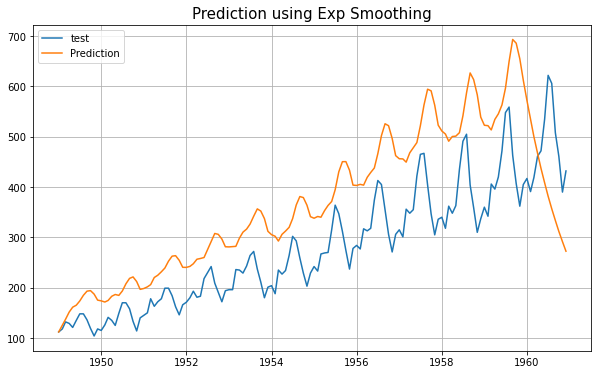

In [33]:
pyplot.plot(df, label = "test")
pyplot.plot(predictions_ExpSm[:-1], label = "Prediction")
pyplot.title('Prediction using Exp Smoothing', fontsize = 15)
pyplot.grid()
pyplot.legend()

In [34]:
print("rmse: " + str(sqrt(mean_squared_error(test, predictions_ExpSm.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_ExpSm.iloc[130:-1])))

rmse: 170.10965234661995
mae: 151.4059616108998


-----

### Question 3.1: Apply Autoregression model ([AR](http://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [35]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random

In [36]:
AR_model = AR(train_logm)
AR_model_fit = AR_model.fit()

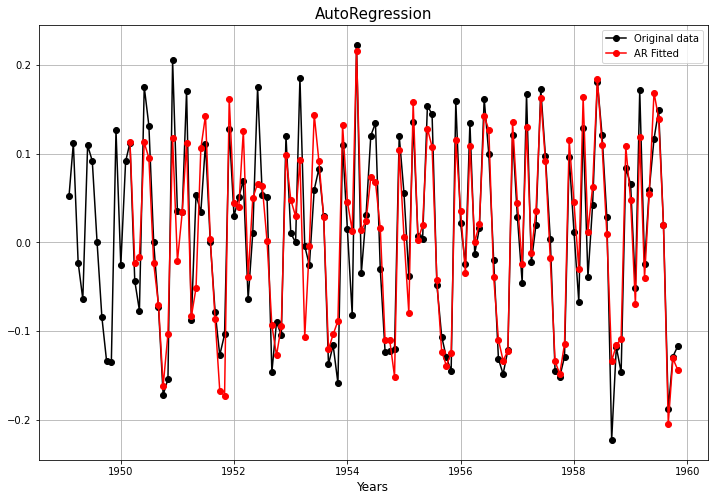

In [37]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(AR_model_fit.fittedvalues, marker="o", color='red', label = "AR Fitted")
pyplot.title('AutoRegression', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [38]:
AR_predictions = AR_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

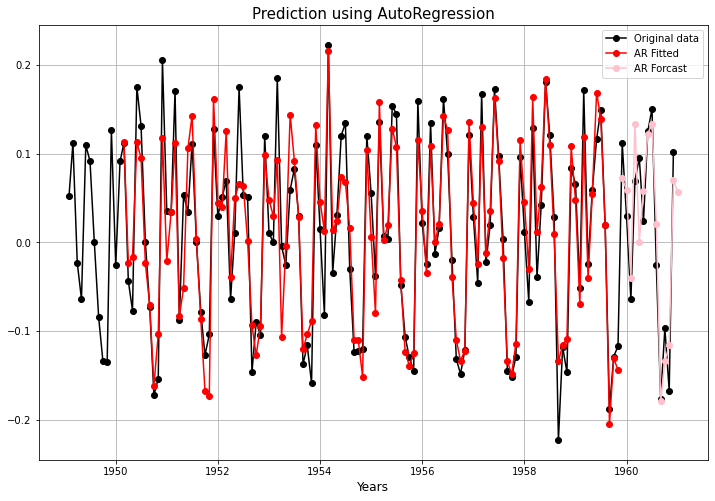

In [39]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(AR_model_fit.fittedvalues, marker="o", color='red', label = "AR Fitted")
pyplot.plot(AR_predictions, marker="o", color='pink', label = "AR Forcast")
pyplot.title('Prediction using AutoRegression', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

In [40]:
predictions_AR_diff = pd.Series(AR_model_fit.fittedvalues, copy=True)
predictions_AR_diff = predictions_AR_diff.append(AR_predictions)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR = np.exp(predictions_AR_log)

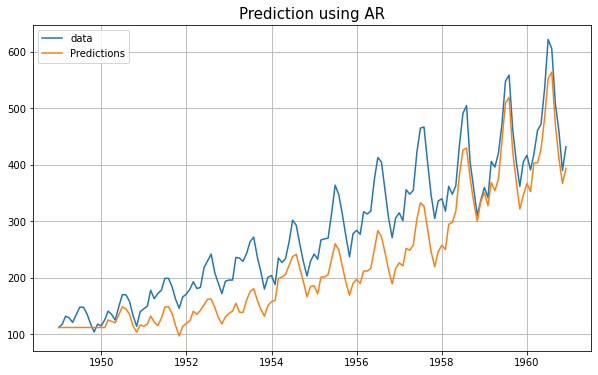

In [41]:
pyplot.plot(df, label = "data")
pyplot.plot(predictions_AR[:-1], label = "Predictions")
pyplot.title('Prediction using AR', fontsize = 15)
pyplot.grid()
pyplot.legend()

In [42]:
print("rmse: " + str(sqrt(mean_squared_error(test, predictions_AR.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_AR.iloc[130:-1])))

rmse: 45.79867724847006
mae: 43.76549981902139


----------

### Question 3.2: Apply Moving Average model [MA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [43]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA

# fit model
MA_model = ARMA(train_logm, order=(0, 1))
MA_model_fit = MA_model.fit(disp=False)

In [44]:
MA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  130
Model:                     ARMA(0, 1)   Log Likelihood                 110.688
Method:                       css-mle   S.D. of innovations              0.103
Date:                Thu, 09 Dec 2021   AIC                           -215.375
Time:                        17:08:42   BIC                           -206.773
Sample:                    02-01-1949   HQIC                          -211.880
                         - 11-01-1959                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0088      0.011      0.771      0.441      -0.014       0.031
ma.L1.passengers     0.2691      0.099      2.714      0.007       0.075       0.463
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.7158           +0.0000j            3.7158            0.5000
-----------------------------------------------------------------------------
"""

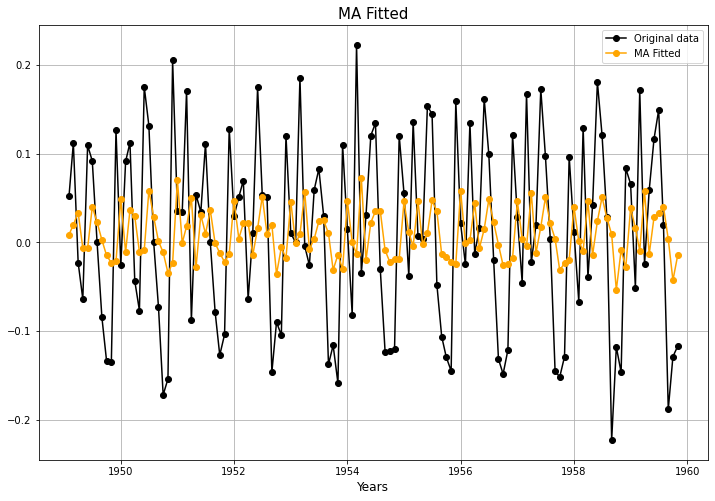

In [45]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(MA_model_fit.fittedvalues, marker="o", color='orange', label = "MA Fitted")
pyplot.title('MA Fitted', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [46]:
MA_predictions = MA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

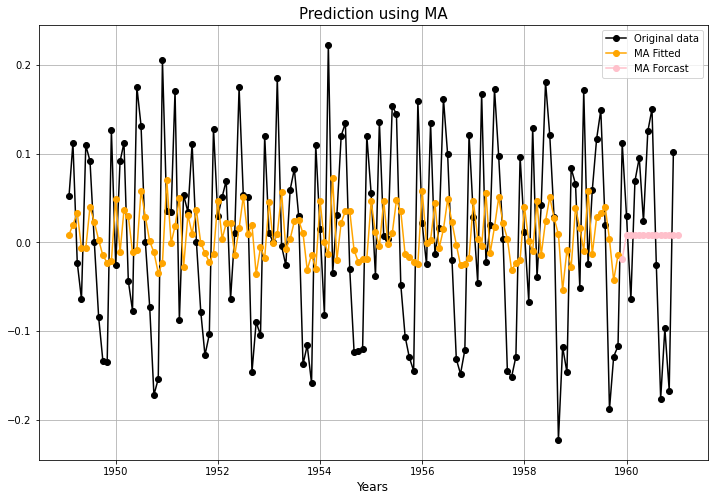

In [47]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(MA_model_fit.fittedvalues, marker="o", color='orange', label = "MA Fitted")
pyplot.plot(MA_predictions, marker="o", color='pink', label = "MA Forcast")
pyplot.title('Prediction using MA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

rmse: 114.59941397154184
mae: 88.59187890667444


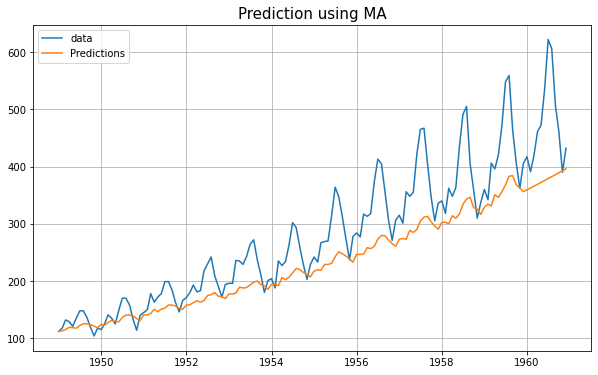

In [48]:
predictions_MA_diff = pd.Series(MA_model_fit.fittedvalues, copy=True)
predictions_MA_diff = predictions_MA_diff.append(MA_predictions)
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA = np.exp(predictions_MA_log)

pyplot.plot(df, label = "data")
pyplot.plot(predictions_MA[:-1], label = "Predictions")
pyplot.title('Prediction using MA', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, predictions_MA.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_MA.iloc[130:-1])))

----------

## Auto Models

### Questio 4.1: Apply Autoregressive Moving Average model ([ARMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [49]:
ARMA_model = ARMA(train, order=(2, 1))
ARMA_model_fit = ARMA_model.fit(disp=False)

In [50]:
ARMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  130
Model:                     ARMA(2, 1)   Log Likelihood                -618.713
Method:                       css-mle   S.D. of innovations             27.821
Date:                Thu, 09 Dec 2021   AIC                           1247.427
Time:                        17:08:42   BIC                           1261.764
Sample:                    01-01-1949   HQIC                          1253.252
                         - 10-01-1959                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              259.5660     54.046      4.803      0.000     153.637     365.495
ar.L1.passengers     0.4216      0.101      4.177      0.000       0.224       0.619
ar.L2.passengers     0.5017      0.102      4.922      0.000       0.302       0.701
ma.L1.passengers     0.9335      0.052     18.089      0.000       0.832       1.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0529           +0.0000j            1.0529            0.0000
AR.2           -1.8932           +0.0000j            1.8932            0.5000
MA.1           -1.0713           +0.0000j            1.0713            0.5000
-----------------------------------------------------------------------------
"""

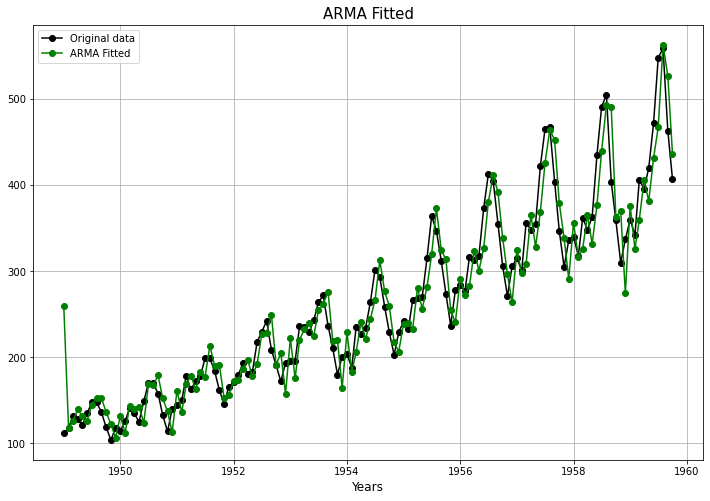

In [51]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train, marker="o", color="black", label = "Original data")
pyplot.plot(ARMA_model_fit.fittedvalues, marker="o", color='green', label = "ARMA Fitted")
pyplot.title('ARMA Fitted', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [52]:
ARMA_predictions = ARMA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [53]:
ARMA_predictions

1959-11-01    396.572855
1959-12-01    391.285797
1960-01-01    383.826001
1960-02-01    378.028892
1960-03-01    371.842708
1960-04-01    366.326626
1960-05-01    360.897845
1960-06-01    355.842036
1960-07-01    350.987254
1960-08-01    346.404326
1960-09-01    342.036849
1960-10-01    337.896578
1960-11-01    333.960175
1960-12-01    330.223696
Freq: MS, dtype: float64

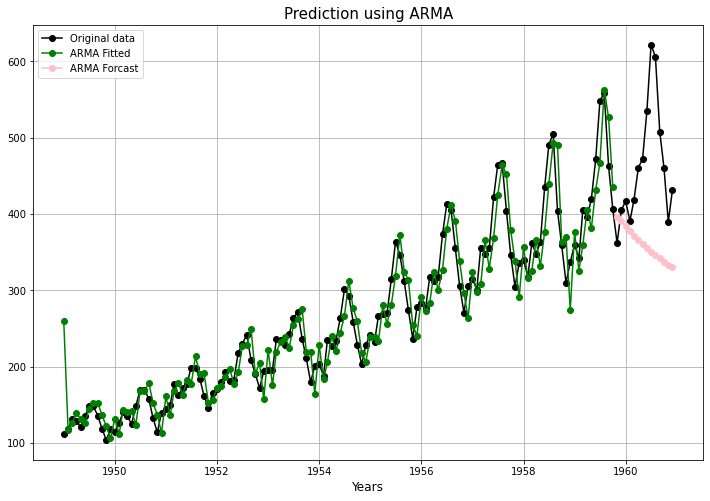

In [54]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(df, marker="o", color="black", label = "Original data")
pyplot.plot(ARMA_model_fit.fittedvalues, marker="o", color='green', label = "ARMA Fitted")
pyplot.plot(ARMA_predictions, marker="o", color='pink', label = "ARMA Forcast")
pyplot.title('Prediction using ARMA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [55]:
print("rmse: " + str(sqrt(mean_squared_error(test, ARMA_predictions))))
print("mae: " + str(mean_absolute_error(test, ARMA_predictions)))

rmse: 135.04368836423086
mae: 107.42957656450994


----------

### Question 4.2: Apply Autoregressive Integrated Moving Average model ([ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [56]:
from statsmodels.tsa.arima_model import ARIMA
ARIMA_model = ARIMA(train, order=(2,1,0))
ARIMA_model_fit = ARIMA_model.fit(disp=1)

In [57]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  129
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -616.779
Method:                       css-mle   S.D. of innovations             28.832
Date:                Thu, 09 Dec 2021   AIC                           1241.557
Time:                        17:08:43   BIC                           1252.996
Sample:                    02-01-1949   HQIC                          1246.205
                         - 10-01-1959                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4150      2.870      0.841      0.400      -3.211       8.041
ar.L1.D.passengers     0.3550      0.086      4.141      0.000       0.187       0.523
ar.L2.D.passengers    -0.2408      0.089     -2.709      0.007      -0.415      -0.067
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7371           -1.8999j            2.0379           -0.1911
AR.2            0.7371           +1.8999j            2.0379            0.1911
-----------------------------------------------------------------------------
"""

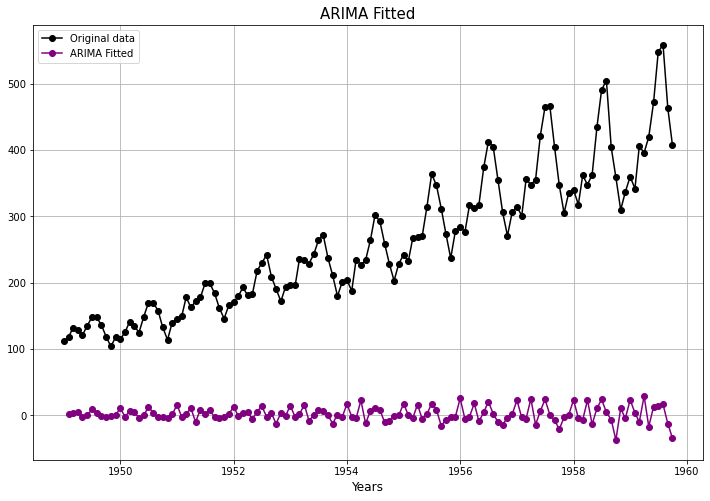

In [58]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train, marker="o", color="black", label = "Original data")
pyplot.plot(ARIMA_model_fit.fittedvalues, marker="o", color='purple', label = "ARIMA Fitted")
pyplot.title('ARIMA Fitted', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [59]:
ARIMA_predictions = ARIMA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

### Question 4.3: Apply AUTO ARIMA Model

In [60]:
from pmdarima.arima import auto_arima
stepwise = auto_arima(train, start_p=1, start_q=1,
                             max_p=3, max_q=3, max_P=3, m=12, #m -> the number of observations per cycle
                             start_P=1, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=889.536, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=885.283, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=886.316, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=884.180, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=885.485, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=885.371, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=884.919, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=885.131, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=886.905, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=885.916, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.126 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  130
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -440.090
Date:                            Thu, 09 Dec 2021   AIC                            884.180
Time:                                    17:08:45   BIC                            889.704
Sample:                                         0   HQIC                           886.423
                                            - 130                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2471      0.090     -2.752      0.006      -0.423      -0.071
sigma2       108.2557     13.261      8.163      0.000      82.264     134.248
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.86   Prob(JB):                         0.73
Heteroskedasticity (H):               1.41   Skew:                            -0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
stepwise.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [62]:
forecast = stepwise.predict(n_periods=14)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

rmse: 15.175621911357792
mae: 11.14009948484813


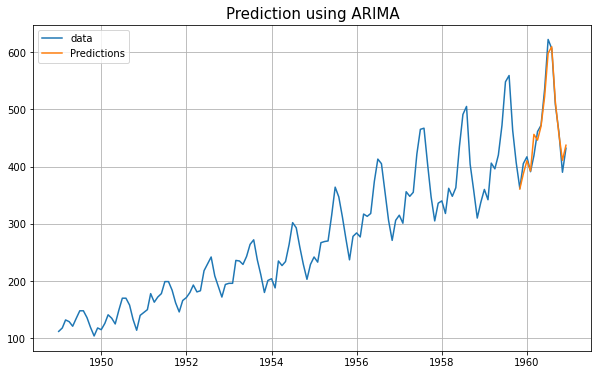

In [63]:
pyplot.plot(df, label = "data")
pyplot.plot(forecast, label = "Predictions")
pyplot.title('Prediction using ARIMA', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, forecast))))
print("mae: " + str(mean_absolute_error(test, forecast)))

### Question 5: After running through various time series models, summarize your findings. 

### Question 6. Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. 

- What was your incoming experience with this model, if any? 
- What steps you took, what obstacles you encountered. 
- How you link this exercise to real-world, machine learning problem-solving?
- What steps were missing? 
- What else do you need to learn?